In [2]:
import numpy as np
import matplotlib.pylab as plt

In [3]:
x = np.random.rand(10,1,28,28)
x.shape

(10, 1, 28, 28)

In [4]:
print(x[0].shape)
print(x[1].shape)

(1, 28, 28)
(1, 28, 28)


In [5]:
x[0,0]

array([[0.60273726, 0.7318977 , 0.77054092, 0.73980581, 0.00557394,
        0.59249984, 0.21839858, 0.14546245, 0.68191755, 0.05102361,
        0.82288797, 0.8024793 , 0.94205459, 0.56159882, 0.80642961,
        0.32160352, 0.32518737, 0.79319988, 0.35774978, 0.20860166,
        0.69884683, 0.84488517, 0.33167129, 0.78145376, 0.00465036,
        0.95878876, 0.22137849, 0.4504531 ],
       [0.20521338, 0.69305465, 0.05487236, 0.87597689, 0.00222614,
        0.05934022, 0.65640047, 0.00824995, 0.60693233, 0.99338523,
        0.97431441, 0.99400425, 0.98540815, 0.13378903, 0.94630588,
        0.43568584, 0.19466475, 0.4788037 , 0.4507511 , 0.75781219,
        0.04614296, 0.37171787, 0.69509269, 0.58074681, 0.7932758 ,
        0.60925718, 0.40910921, 0.23934709],
       [0.95786838, 0.97171367, 0.31777565, 0.11780248, 0.86493453,
        0.26059817, 0.55819128, 0.3450253 , 0.15311566, 0.11701759,
        0.60775248, 0.44210277, 0.69504048, 0.70995505, 0.5049363 ,
        0.55458367, 0.6211

In [6]:
from common.util import im2col

x1 = np.random.rand(1,3,7,7)  # (data size, channel size, height, width)
col1 = im2col(x1, 5,5,stride=1,pad=0)
print(col1.shape)

x2 = np.random.rand(10,3,7,7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [7]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = strdie
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b

        out = out.reshape(N, out_h, out_w, -1).transpose(0,3,1,2)

        return out

In [8]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = strdie
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        out = np.max(col, axis=1)

        out = out.reshape(N, out_h, out_w, C).transpose(0,3,1,2)

        return out

In [9]:
import pickle
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size
    hidden_size_list
    output_size
    activation
    weight_init_std
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # initialize parameters
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # make layers
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """loss function

        Parameters
        ----------
        x : input data
        t : answer label
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """numerical diffierentiation

        Parameters
        ----------
        x : input data
        t : answer label

        
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """back propagation

        Parameters
        ----------
        x : input data
        t : answer label

        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # save result
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.3000778997116216
=== epoch:1, train acc:0.173, test acc:0.197 ===
train loss:2.297601637360273
train loss:2.2928615850540943
train loss:2.2876583110242965
train loss:2.2764407255302945
train loss:2.2641889632578076
train loss:2.2645897049084365
train loss:2.235793543627772
train loss:2.2094787717931506
train loss:2.19628465864635
train loss:2.148449160250265
train loss:2.1281062499167716
train loss:2.049536586278941
train loss:2.004729019682027
train loss:1.9776025555251406
train loss:1.8952116465140278
train loss:1.8485508741578862
train loss:1.774702224875361
train loss:1.6736523147984708
train loss:1.5429333351328165
train loss:1.5240260067299554
train loss:1.4605747091503156
train loss:1.3493868759717031
train loss:1.2960417718201527
train loss:1.130194660394968
train loss:1.1553396091742882
train loss:1.0355803183220005
train loss:0.8805668753664218
train loss:0.9774553626271755
train loss:0.8811686723834409
train loss:0.7303672067953485
train loss:0.7148495398921542


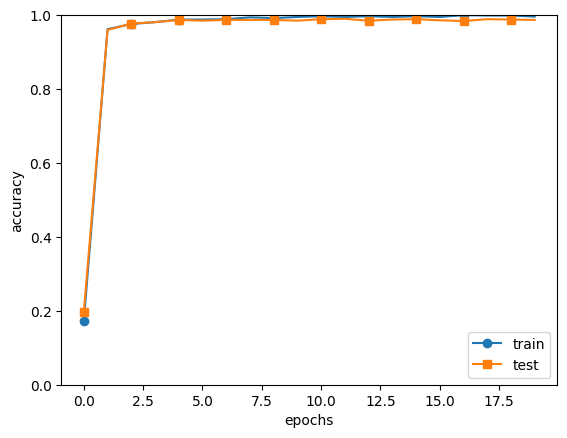

In [10]:
from common.trainer import Trainer
from dataset.mnist import load_mnist


(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

network.save_params("params.pkl")
print("Saved Network Parameters!")

markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()